In [1]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
from matplotlib import patches as patches
import cv2

import os

In [2]:
train_data = pd.read_json("C:/Users/Adam/Desktop/ISA/projekty/4_DL_project/training.json")
test_data = pd.read_json("C:/Users/Adam/Desktop/ISA/projekty/4_DL_project/test.json")
print(train_data.shape, test_data.shape)

(1208, 2) (120, 2)


In [3]:
test_data.head()

,image,objects
0,{'checksum': 'eea3bfd6a929bcb06f9786667cd3fbb2...,"[{'bounding_box': {'minimum': {'r': 576, 'c': ..."
1,{'checksum': '2d85fc8ffdb875bb569878243437e4f5...,"[{'bounding_box': {'minimum': {'r': 1048, 'c':..."
2,{'checksum': 'f7c02b6247f3ccfcd4a22c1f06e0c72c...,"[{'bounding_box': {'minimum': {'r': 979, 'c': ..."
3,{'checksum': '50634ef166ae993b4562b96f315ff6db...,"[{'bounding_box': {'minimum': {'r': 402, 'c': ..."
4,{'checksum': '74dd777a74e5a4b24aaee574a99e1459...,"[{'bounding_box': {'minimum': {'r': 314, 'c': ..."


In [4]:
print(test_data['image'].sample().values, "\n",
      test_data['objects'].sample().values)

[{'checksum': 'e8718aa637c7950c54f570b04218de62', 'pathname': '/images/91fd0c2e-8e9c-452d-97ab-304b05a049b3.jpg', 'shape': {'r': 1383, 'c': 1944, 'channels': 3}}] 
 [list([{'bounding_box': {'minimum': {'r': 314, 'c': 1054}, 'maximum': {'r': 433, 'c': 1186}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 1080, 'c': 48}, 'maximum': {'r': 1188, 'c': 170}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 38, 'c': 1105}, 'maximum': {'r': 171, 'c': 1235}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 856, 'c': 1012}, 'maximum': {'r': 994, 'c': 1143}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 700, 'c': 657}, 'maximum': {'r': 820, 'c': 788}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 465, 'c': 249}, 'maximum': {'r': 581, 'c': 385}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 189, 'c': 500}, 'maximum': {'r': 321, 'c': 648}}, 'category': 'red blood cell'}, {'bounding

In [5]:
# creating dataframe with each bounding box as datapoint
test_image_list = [] # pathname
width = []            # width of the image
height = []           # height of the image
    # position of the bbox
y_max = []
y_min = []
x_max = []
x_min = []
    # label
class_label = []

for i in range(0,test_data.shape[0]):
    for j in range(0,len(test_data["objects"][i])):
        
        test_image_list.append(test_data["image"][i]["pathname"])
        
        width.append(test_data["image"][i]["shape"]["c"])
        height.append(test_data["image"][i]["shape"]["r"])
        
        y_max.append(test_data["objects"][i][j]["bounding_box"]["maximum"]["r"])
        y_min.append(test_data["objects"][i][j]["bounding_box"]["minimum"]["r"])
        x_max.append(test_data["objects"][i][j]["bounding_box"]["maximum"]["c"])
        x_min.append(test_data["objects"][i][j]["bounding_box"]["minimum"]["c"])
        
        class_label.append(test_data["objects"][i][j]["category"])
        
test_df = pd.DataFrame()

test_df["filepath"] = test_image_list
test_df["width"] = width
test_df["height"] = height
test_df["class_label"] = class_label
test_df["xmin"] = x_min
test_df["ymin"] = y_min
test_df["xmax"] = x_max
test_df["ymax"] = y_max

test_df.head()

,filepath,width,height,class_label,xmin,ymin,xmax,ymax
0,/images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg,1944,1383,red blood cell,1744,576,1883,708
1,/images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg,1944,1383,red blood cell,1249,863,1373,977
2,/images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg,1944,1383,red blood cell,1573,210,1711,335
3,/images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg,1944,1383,red blood cell,1124,1017,1253,1142
4,/images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg,1944,1383,red blood cell,1655,572,1763,695


In [6]:
test_df["filepath"].nunique()

120

In [7]:
test_df["class_label"].value_counts()

red blood cell    5614
ring               169
trophozoite        111
gametocyte          12
schizont            11
difficult            5
Name: class_label, dtype: int64

In [9]:
test_df.replace({'leukocyte': 'red blood cell', 
                  'trophozoite': 'malaria', 
                  'difficult': 'malaria', 
                  'ring': 'malaria', 
                  'schizont': 'malaria', 
                  'gametocyte': 'malaria'}, inplace=True)

In [11]:
test_df["class_label"].value_counts()

red blood cell    5614
malaria            308
Name: class_label, dtype: int64

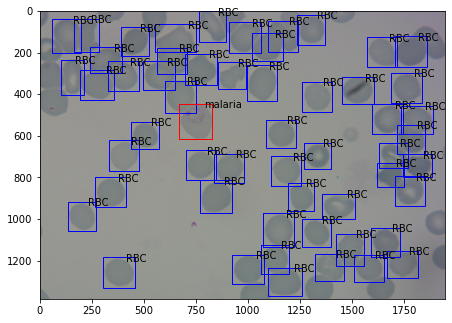

In [12]:
fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('images/03be08c8-2cf3-4de6-8ac6-5f7817a6a643.jpg')
plt.imshow(image)


# iterating over the image for different objects
for _, row in test_df[test_df.filepath == "/images/03be08c8-2cf3-4de6-8ac6-5f7817a6a643.jpg"].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    
    width = xmax - xmin
    height = ymax - ymin
    # assign different color to different classes of objects
    if row.class_label == 'red blood cell':
        edgecolor = 'b'
        ax.annotate('RBC', xy=(xmax-40,ymin+20))
    elif row.class_label == 'malaria':
        edgecolor = 'r'
        ax.annotate('malaria', xy=(xmax-40,ymin+20))
        
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)